# Train a random-forest classifier

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv("../../data/processed/stanford-all.csv", index_col=0)

In [3]:
df.shape

(31014, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31014 entries, 0 to 31013
Data columns (total 2 columns):
content    31014 non-null object
label      31014 non-null int64
dtypes: int64(1), object(1)
memory usage: 726.9+ KB


### Balance classes

To avoid bias (i.e. when an algorithm prefers one class to the other) we need to have an equal number of elements for each class.

In [5]:
df.groupby('label').count()

,content
label,
0,11273
1,19741


First let's count the elements of the minority class.

In [6]:
n_elements = (df['label']==0).sum()
n_elements

11273

Then sample an equal number from the majority class.

In [7]:
df_positive = df[df['label']==1].sample(n_elements, random_state=42)
df_positive.head()

,content,label
10724,@DYKE_37 O que DST?,1
15443,A buzz cut does not a dyke make,1
7968,@my_suhr_guitar @KondratieffWave @NicolaSturge...,1
30805,@lovedayas THIS WASNT EVEN FUNNY BITCH OAK,1
30564,@DreadLegend_ Its gone be all worth it when im...,1


In [8]:
df_balanced = pd.concat((df[df['label']==0], df_positive)).reset_index(drop=True)
df_balanced

,content,label
0,The new Doras cute af,0
1,@minniemonikive well,0
2,@tangletorn We will be killed by a snake 3,0
3,@ATX_fight_club @AOC JFK was a clandestine aus...,0
4,@ocorreia_ @skank_ @duudamarquess_ eu tambm kk...,0
...,...,...
22541,@blackearnside @richardqspencer @BBCsarahsmith...,1
22542,Hope shes having a wonderful time with her won...,1
22543,hnn i want to be humiliated and degraded for b...,1
22544,Message to.. 1. Be good 2. Thanks for making m...,1


We store the balanced data in the original dataframe.

In [9]:
df = df_balanced

Now let's create the Spacy NLP documents from our text data:

In [10]:
nlp = spacy.load("en_core_web_md")

In [11]:
docs = list(nlp.pipe(df['content']))

### Vectors visualization

Here we take the document vectors from Spacy.

In [12]:
vector_matrix = np.array(list(map(lambda x: x.vector, docs)))

In [13]:
vector_matrix.shape

(22546, 300)

We use PCA to project the vectors to their principal components.

In [14]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(2)

In [18]:
x_pca = pca.fit_transform(vector_matrix)

In [19]:
x_pca.shape

(22546, 2)

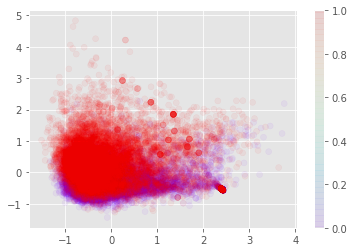

In [20]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['label'].tolist(), alpha=.05, cmap='rainbow');
plt.colorbar();

## Random forest classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [23]:
from sklearn.model_selection import train_test_split

### Train-test split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    vector_matrix,
    df['label'].tolist(),
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [27]:
x_train.shape

(18036, 300)

In [28]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [29]:
y_pred = rf.predict(x_test)

In [30]:
y_proba = rf.predict_proba(x_test)

In [31]:
from sklearn.metrics import auc

In [32]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve

In [33]:
f1_score(y_test, y_pred)

0.7657938986307952

In [34]:
f1_score(y_train, rf.predict(x_train))

0.9867564534231201

In [35]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [36]:
y_proba

array([[0.58, 0.42],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       ...,
       [0.57, 0.43],
       [0.68, 0.32],
       [0.44, 0.56]])

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

In [38]:
auc(fpr, tpr)

0.8470107816579073

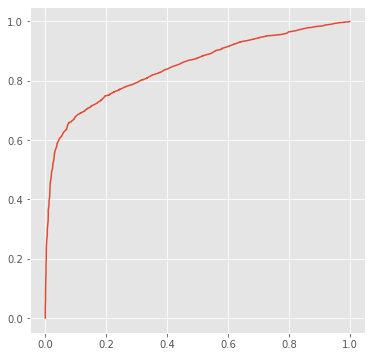

In [39]:
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr);

In [40]:
rf.n_features_

300

In [45]:
df_train, df_test = train_test_split(
    df,
    train_size=.8,
    shuffle=True,
    stratify=df['label'],
    random_state=42,
)

In [46]:
df_train.shape

(18036, 2)

In [47]:
df_test.shape

(4510, 2)

In [48]:
df_test['prediction'] = y_proba[:, 1]

/home/guzzo/anaconda3/envs/find-out/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's take a look at what the model predicts.

In [49]:
df_test[df_test['prediction']>.5].sort_values('prediction', ascending=False)['content'].tolist()

['@knukklehedd OH YOU FUCKING BITCH',
 '@nataliee_fr dyke',
 '@_LoveVsLust12 @dykemeetsworld This bitch still tryna justify her cheating dyke ass ways.',
 'Never will I dislike girl bc she fw ma ex but this bitch really tryna fucc on my ex',
 'This bitch https//t.co/nV3EbKWxWm',
 'Uh this bitch tryna get on my ass',
 '@27nads @mel_aozz You fucking bitch',
 'im a white mans whore https//t.co/90Tl7EGtM7',
 'THIS BITCH https//t.co/KpV0Sgnwwe',
 '@henderysjuul dyke',
 'I hope the stupid fucking ass fuck in the black stupid bitch cunt ass truck chokes on a fucking lightbulb. Stupid fucking whore.',
 '*walks past my crush* Me Hey you dumb fucking bitch ass cunt hoe, whats up?',
 'Ttu is just a fucking bitch https//t.co/mKixzB7hWD',
 'I WULL NEVER BE OVER THIS BRUHSHSBSHDBD HES SO FUCKING WHORE LIKE FUCKING WHORE BITCH https//t.co/pLzXhzpkmC',
 '@myrkaakrym Fucking bitch',
 'My mouths gonna hurt trynna eat this chipotle but I dont give a fuck bitch',
 '@sunflcwerfeelin @unstiteo bitch what',


In [50]:
df_test[df_test['prediction']<=.5].sort_values('prediction', ascending=False)['content'].tolist()

["@Hakyeons_bitch Yes and please don't mind our fancy brain",
 '@xlofreex Tudo pelo meu beb',
 'Joes room smells like a dirty little boy but i seriously get so much comfort from it',
 '@AOC Theyre not dehumanizing policies. Theyre policies that apply to humans. Furthermore, violating someones rights is not necessarily dehumanizing.',
 '@AOC Pathetic',
 'se le malca el camel toe a la condenaa',
 '@itsericathomas @itsericathomas used her race, her sex and the fact she is pregnant. What a dirty lowdown thing to do just to try and smear white America. She is the racist one and does not need to hold any public job. Step down!',
 '@WajahatAli @AOC Ignorant',
 '@DYKE_37 @mandrakedrake22 Tbm quero',
 '@ScottPresler @AOC Ooo Scott! Great!',
 'Spending more than a hundred thousand for this bitch! So be responsible',
 '@Krnaa_ Put Kill or be Killed by spite, you aint gotta thank me...',
 '@JessicaValenti @benchten Thank you for posting this Benmont',
 'Day 2 French lecturer says a dirty home is a

### Visualization of probability distribution

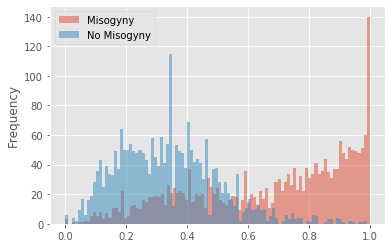

In [51]:
df_test['prediction'][df_test['label']==1].plot.hist(bins=99, alpha=.5, label="Misogyny")
df_test['prediction'][df_test['label']!=1].plot.hist(bins=99, alpha=.5, label="No Misogyny");
plt.legend();

### Parameter Optimization

In [52]:
from sklearn.model_selection import GridSearchCV

In [53]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
# BEWARE: Searching for more than just a couple parameters will increase the calculation time exponentially!
param_grid = {
    "n_estimators": [50, 200],
#     "max_depth": [3, None],
#     "max_features": [1, 10, 100],
#     "min_samples_split": [10, 100, 1000],
#     "bootstrap": [True, False],
#     "criterion": ["gini", "entropy"],
}

In [55]:
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=5, iid=False, verbose=2, n_jobs=-1)

In [56]:
%%time
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.0min remaining:   26.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


CPU times: user 1min 48s, sys: 296 ms, total: 1min 48s
Wall time: 1min 20s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=-1, param_grid={'n_estimators': [50

In [57]:
grid_search.cv_results_

{'mean_fit_time': array([17.04334583, 54.61357374]),
 'std_fit_time': array([0.35301269, 5.48507988]),
 'mean_score_time': array([0.30315194, 0.32502627]),
 'std_score_time': array([0.06150347, 0.17943807]),
 'param_n_estimators': masked_array(data=[50, 200],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 50}, {'n_estimators': 200}],
 'split0_test_score': array([0.76967849, 0.77466741]),
 'split1_test_score': array([0.78381375, 0.79268293]),
 'split2_test_score': array([0.77937916, 0.78575388]),
 'split3_test_score': array([0.77287854, 0.77981143]),
 'split4_test_score': array([0.78757626, 0.79062673]),
 'mean_test_score': array([0.77866524, 0.78470847]),
 'std_test_score': array([0.00664335, 0.00670097]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [58]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [59]:
f1_score(y_test, grid_search.predict(x_test))

0.7688249400479616

In [60]:
y_proba = grid_search.predict_proba(x_test)[:, 1]

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

In [62]:
auc(fpr, tpr)

0.848497500012291

In [64]:
def plot_roc_auc_f1(y_test, y_proba, title=None):
    f1 = f1_score(y_test, y_proba>.5)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    if title is not None:
        ax.set_title(title)
    ax.plot([0, 1], [0, 1], '--')
    ax.plot(fpr, tpr)
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.annotate(f"AUC: {auc_score:.4}", (.8, 0.05))
    ax.annotate(f"F1: {f1:.4}", (.8, 0.0))
    return f1, auc_score

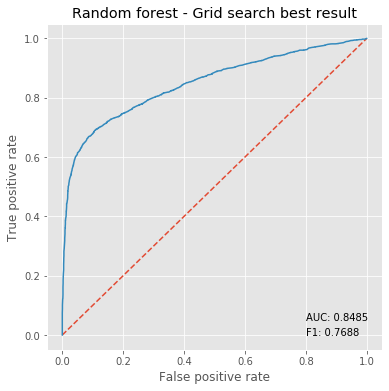

In [65]:
plot_roc_auc_f1(y_test, y_proba, title="Random forest - Grid search best result");

## TODOs

- Balance data
- Fill in text